In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
#creating an instance
dd=unpickle('Datasets/data_batch_1')

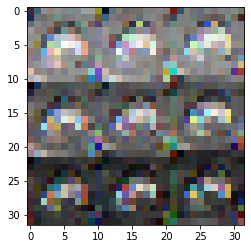

In [4]:
#showing the first image from data
img=dd[b'data'][0]
img.shape=(32,32,3)
plt.imshow(img)

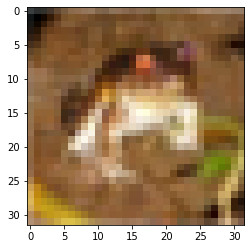

In [5]:
#reshaping the data and showing the result
img=img.reshape(3,32,32).transpose(1,2,0)
plt.imshow(img)

## Train Test Split:

In [6]:
X=dd[b'data']
X

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [7]:
Y=np.array(dd[b'labels'])
Y.shape

(10000,)

In [8]:
from sklearn.model_selection import train_test_split

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8


# In the first step we will split the data in training and remaining dataset
x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.8)

## Model-Creation,Training & Visualization

In [9]:
from sklearn.tree import DecisionTreeClassifier

dc=DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')
dc.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')

In [10]:
def train_estimators(X, y, estimator_type, **kwargs):
    
    clf = estimator_type( random_state=0,**kwargs)
    clf.fit(X, y)
                
    return clf

In [11]:
def plot_estimator_scores(estimator,**kwargs):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need.
    
    x=1
    list_tr=[]
    list_tst=[]
    list_val=[]
    list_par_val=[]
    estimtr=0
    s=-4
    s1=-2
    for i in range(1,6):
        
        if estimator==DecisionTreeClassifier or estimator==RandomForestClassifier:
        
            estimtr=train_estimators(x_train, y_train, estimator,
                                    max_depth=i*5*x)
        elif estimator==LogisticRegression:
            estimtr=train_estimators(x_train, y_train, estimator,
                                    C=10**s,max_iter=10000)

            s=s+1
            
        elif estimator==SVC:
            
            
            estimtr=train_estimators(x_train, y_train, estimator,
                                    C=10**s1,max_iter=10000,gamma=0.001)
            s1=s1+1
    
        list_tr.append(score_estimators(x_train, y_train,estimtr))
#         list_tst.append(score_estimators(X_valid, y_valid,estimtr))
        list_tst.append(score_estimators(x_test, y_test,estimtr))
        list_par_val.append(i*5*x)
        x=x+1
        
    plt.plot(list_par_val,list_tr, label='training')
    plt.scatter(list_par_val,list_tr,)
    plt.plot(list_par_val,list_tst, label='testing')
    plt.scatter(list_par_val,list_tst)
    
    plt.legend()
    return list_tr,list_tst,list_val

In [12]:
def score_estimators(X, y,estimator):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    return estimator.score(X, y)


([0.298, 0.991875, 1.0, 1.0, 1.0],
 [0.2175, 0.2255, 0.2255, 0.2255, 0.2255],
 [])

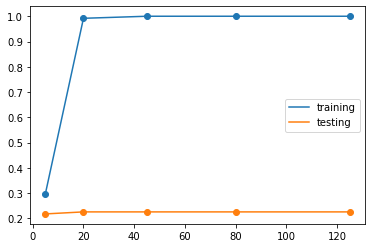

In [13]:
plot_estimator_scores(DecisionTreeClassifier)

# Convolution Neural Network

In [23]:
import torch
import numpy as np
from torchsummary import summary

In [15]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [16]:
import torch.nn as nn
import torch.nn.functional as F

train_on_gpu = False

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [24]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 500]         512,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.06
Estimated T

In [17]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train the Network
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [21]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:

        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.161567 	Validation Loss: 1.109509
Validation loss decreased (inf --> 1.109509).  Saving model ...
Epoch: 2 	Training Loss: 1.092997 	Validation Loss: 1.058327
Validation loss decreased (1.109509 --> 1.058327).  Saving model ...
Epoch: 3 	Training Loss: 1.029492 	Validation Loss: 1.007341
Validation loss decreased (1.058327 --> 1.007341).  Saving model ...
Epoch: 4 	Training Loss: 0.976993 	Validation Loss: 0.936806
Validation loss decreased (1.007341 --> 0.936806).  Saving model ...
Epoch: 5 	Training Loss: 0.926721 	Validation Loss: 0.907022
Validation loss decreased (0.936806 --> 0.907022).  Saving model ...
Epoch: 6 	Training Loss: 0.882926 	Validation Loss: 0.860414
Validation loss decreased (0.907022 --> 0.860414).  Saving model ...
Epoch: 7 	Training Loss: 0.847395 	Validation Loss: 0.837179
Validation loss decreased (0.860414 --> 0.837179).  Saving model ...
Epoch: 8 	Training Loss: 0.804651 	Validation Loss: 0.818304
Validation loss decreased (0.83717

## Test the Trained Network
Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [22]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
# iterate over test data
for data, target in test_loader:
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.736681

Test Accuracy of airplane: 79% (798/1000)
Test Accuracy of automobile: 89% (894/1000)
Test Accuracy of  bird: 58% (587/1000)
Test Accuracy of   cat: 51% (518/1000)
Test Accuracy of  deer: 69% (691/1000)
Test Accuracy of   dog: 72% (725/1000)
Test Accuracy of  frog: 89% (897/1000)
Test Accuracy of horse: 76% (761/1000)
Test Accuracy of  ship: 85% (858/1000)
Test Accuracy of truck: 80% (807/1000)

Test Accuracy (Overall): 75% (7536/10000)
